In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## **DATA**

infant - Mortality rates for infants (<1).

u5mr - Mortality rates for under-5 years old (U5MR).

WHO has not grouped infant mortality by gender.

In [4]:
u5mr_totals = pd.read_csv(r"C:\Users\Clyf\Downloads\Total_KE.csv")
u5mr_females = pd.read_csv(r"C:\Users\Clyf\Downloads\Females_KE.csv")
u5mr_males = pd.read_csv(r"C:\Users\Clyf\Downloads\Males_KE.csv")

infant_totals = pd.read_csv(r"C:\Users\Clyf\Downloads\INFANT MORTALITY RATE.csv")

### **Defining Lee-Carter Model (LC)**

In [6]:
def lee_carter_model(data):
    years = data['Year'].values.reshape(-1, 1)
    mortality = data['Rate'].values

    X = np.column_stack([np.ones(len(years)), years]) #for Lee-Carter: X = [1, years]
    y = np.log(mortality)

    model = LinearRegression() #Fitting the model
    model.fit(X, y)

    alpha = model.intercept_
    beta = model.coef_[1]
    kappa = model.predict(X) - alpha - beta * years
    
    return alpha, beta, kappa

### **Defining CBD Model**

In [8]:
def cbd_model(data):
    years = data['Year']
    mortality = data['Rate']

    X = np.column_stack([np.ones(len(years)), years])
    y = np.log(mortality)

    model = LinearRegression()
    model.fit(X, y)
    
    alpha = model.intercept_
    beta = model.coef_[1]
    delta = model.predict(X) - alpha - beta * years
    
    return alpha, beta, delta

### **Define Lookback Windows**

Loop through various lookback windows to estimate mortality rates using both models.

In [10]:
lookback_windows = [
    (1954, 1964),
    (1965, 1974),
    (1975, 1984),
    (1985, 1994),
    (1995, 2004),
    (2005, 2014),
    (2015, 2022)
    ]

### Model application
- Here, infant and under-five mortality data is processed across specified year ranges (defined above).
- For each range, it applies the **Lee-Carter** and **CBD models** to filter data for age groups 0-1 and 1-4. 
- The models are applied to compute parameters **(alpha, beta, kappa for Lee-Carter; alpha, beta, delta for CBD)** for the infant (0-1 age group) and under-5 (1-4 age group) populations.

#### Results 
These are the **model parameters** stored in a **list** to be retrieved later.

In [66]:
results = []

for start_year, end_year in lookback_windows:
    filtered_infant_data = infant_totals[(infant_totals['Year'] >= start_year) & (infant_totals['Year'] <= end_year)] #Processing 0-1 Age Group (from infant_totals)
    
    if not filtered_infant_data.empty:
        alpha_lc_infant, beta_lc_infant, kappa_lc_infant = lee_carter_model(filtered_infant_data) #Applying the Lee-Carter model to the 0-1 age group
        
        alpha_cbd_infant, beta_cbd_infant, delta_cbd_infant = cbd_model(filtered_infant_data) #Applying CBD model
        
    else:
        alpha_lc_infant, beta_lc_infant, kappa_lc_infant = np.nan, np.nan, np.nan
        alpha_cbd_infant, beta_cbd_infant, delta_cbd_infant = np.nan, np.nan, np.nan

    filtered_u5mr_data = u5mr_totals[(u5mr_totals['Year'] >= start_year) & (u5mr_totals['Year'] <= end_year)] #Processing 1-4 Age Group (from u5mr_totals, _females, and _males)
    
    if not filtered_u5mr_data.empty:
        alpha_lc_u5mr, beta_lc_u5mr, kappa_lc_u5mr = lee_carter_model(filtered_u5mr_data) #Applying LC
        
        alpha_cbd_u5mr, beta_cbd_u5mr, delta_cbd_u5mr = cbd_model(filtered_u5mr_data) #Applying CBD
        
    else:
        alpha_lc_u5mr, beta_lc_u5mr, kappa_lc_u5mr = np.nan, np.nan, np.nan
        alpha_cbd_u5mr, beta_cbd_u5mr, delta_cbd_u5mr = np.nan, np.nan, np.nan
    
    # Forecasting future mortality rates
    forecast_lc_infant = alpha_lc_infant + beta_lc_infant * forecast_years + np.mean(kappa_lc_infant)
    forecast_cbd_infant = alpha_cbd_infant + beta_cbd_infant * forecast_years + np.mean(delta_cbd_infant)

    forecast_lc_u5mr = alpha_lc_u5mr + beta_lc_u5mr * forecast_years + np.mean(kappa_lc_u5mr)
    forecast_cbd_u5mr = alpha_cbd_u5mr + beta_cbd_u5mr * forecast_years + np.mean(delta_cbd_u5mr)

    results.append({
        "start_year": start_year,
        "end_year": end_year,
        "LC_alpha_infant": alpha_lc_infant,
        "LC_beta_infant": beta_lc_infant,
        "LC_kappa_infant": np.nanmean(kappa_lc_infant),
        "CBD_alpha_infant": alpha_cbd_infant,
        "CBD_beta_infant": beta_cbd_infant,
        "CBD_delta_infant": np.nanmean(delta_cbd_infant),
        "LC_alpha_u5mr": alpha_lc_u5mr,
        "LC_beta_u5mr": beta_lc_u5mr,
        "LC_kappa_u5mr": np.nanmean(kappa_lc_u5mr),
        "CBD_alpha_u5mr": alpha_cbd_u5mr,
        "CBD_beta_u5mr": beta_cbd_u5mr,
        "CBD_delta_u5mr": np.nanmean(delta_cbd_u5mr),
        "forecast_LC_infant": forecast_lc_infant.tolist(),
        "forecast_CBD_infant": forecast_cbd_infant.tolist(),
        "forecast_LC_u5mr": forecast_lc_u5mr.tolist(),
        "forecast_CBD_u5mr": forecast_cbd_u5mr.tolist(),
    })

In [68]:
results_df = pd.DataFrame(results)
print(results_df)

   start_year  end_year  LC_alpha_infant  LC_beta_infant  LC_kappa_infant  \
0        1954      1964        63.640732       -0.030486              0.0   
1        1965      1974        35.206022       -0.016007              0.0   
2        1975      1984        38.776358       -0.017822              0.0   
3        1985      1994        28.419972       -0.012612              0.0   
4        1995      2004        32.092082       -0.014433              0.0   
5        2005      2014         9.713911       -0.003292              0.0   
6        2015      2022        25.565909       -0.011150              0.0   

   CBD_alpha_infant  CBD_beta_infant  CBD_delta_infant  LC_alpha_u5mr  \
0         63.640732        -0.030486               0.0      95.009931   
1         35.206022        -0.016007               0.0      48.763126   
2         38.776358        -0.017822               0.0      72.148576   
3         28.419972        -0.012612               0.0     -31.558915   
4         32.09208

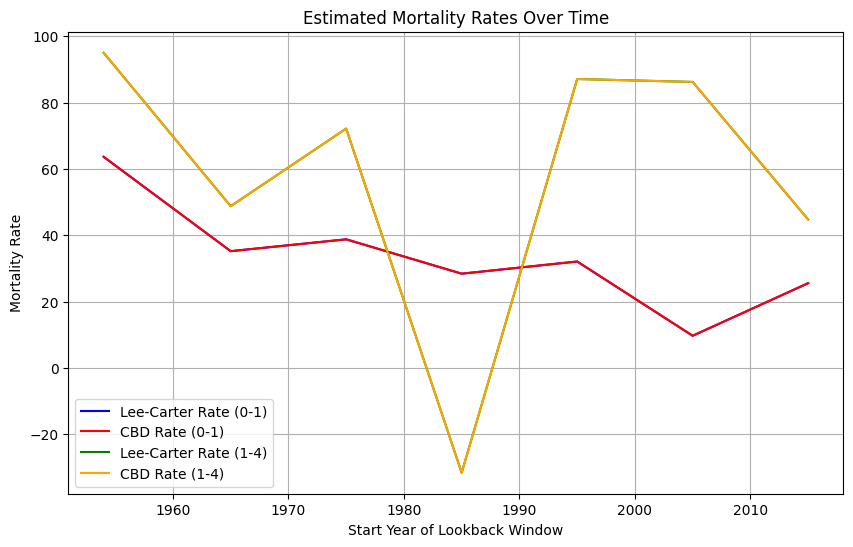

In [63]:
#Visualizing the forecasted mortality rates

plt.figure(figsize=(10, 6))

plt.plot(results_df['start_year'], results_df['LC_alpha_infant'], label='Lee-Carter Rate (0-1)', color='blue')
plt.plot(results_df['start_year'], results_df['CBD_alpha_infant'], label='CBD Rate (0-1)', color='red')
plt.plot(results_df['start_year'], results_df['LC_alpha_u5mr'], label='Lee-Carter Rate (1-4)', color='green')
plt.plot(results_df['start_year'], results_df['CBD_alpha_u5mr'], label='CBD Rate (1-4)', color='orange')

plt.title('Estimated Mortality Rates Over Time')
plt.xlabel('Start Year of Lookback Window')
plt.ylabel('Mortality Rate')
plt.legend()
plt.grid(True)
plt.show()

# FORECASTING MORTALITY

In [92]:
# Find the index of 2030 in forecast_years
index_2030 = np.where(forecast_years == 2030)[0][0]

# Get the forecasted mortality rate for 2030
forecast_LC_infant_2030 = np.mean(results_df['forecast_LC_infant'].apply(lambda x: x[index_2030]).values)
forecast_CBD_infant_2030 = np.mean(results_df['forecast_CBD_infant'].apply(lambda x: x[index_2030]).values)

forecast_LC_u5mr_2030 = np.mean(results_df['forecast_LC_u5mr'].apply(lambda x: x[index_2030]).values)
forecast_CBD_u5mr_2030 = np.mean(results_df['forecast_CBD_u5mr'].apply(lambda x: x[index_2030]).values)

# Print the results
print(f"Forecasted Mortality Rate for 2030:")
print(f"Lee-Carter (0-1 years): {forecast_LC_infant_2030}")
print(f"CBD (0-1 years): {forecast_CBD_infant_2030}")
print(f"Lee-Carter (1-4 years): {forecast_LC_u5mr_2030}")
print(f"CBD (1-4 years): {forecast_CBD_u5mr_2030}")

Forecasted Mortality Rate for 2030:
Lee-Carter (0-1 years): 2.6623559379633233
CBD (0-1 years): 2.6623559379633233
Lee-Carter (1-4 years): 3.451436644894096
CBD (1-4 years): 3.451436644894096
